In [1]:
#including elements of ipython necessary for notebook formatting and display
from IPython.display import display, Markdown, Latex, IFrame

# LS8 Suspect Pixel Selection Tool
Designed for Landsat 8 OLI - Multiband Rasters in .tif image format.

Multiband image directory path must include four files, including 
the following formats: [.tif, .tif.ovr, .tfw, .tif.aux.xml] to ensure 
    image metadata is available for band combinations and image 
    transformations.

<b><u>Reference Documents:</u></b>
    <br>
    <a href="https://landsat.gsfc.nasa.gov/landsat-8/landsat-8-overview">Landsat 8 Overview (NASA Website)</a>

# Landsat 8 User Handbook
<i>(PDF Source: https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1574_L8_Data_Users_Handbook-v5.0.pdf)</i>

In [2]:
#embed LS8 User Manual document
IFrame("LSDS-1574_L8_Data_Users_Handbook-v5.0.pdf", width=900, height=300)

In [32]:
#include packages necessary for image processing and display
import os
import matplotlib.pyplot as plt
import numpy as np
import arcpy
%matplotlib inline
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
from glob import glob
import natsort
import rasterio
from rasterio.plot import show

# File Path and Image ID

In [4]:
#prompt for image working directory file path (variable type: string)
directory = input("Please enter the full file path to the directory containing your imagery:\r")
#print(directory) #debug statement

# Set working directory
os.chdir(directory)

#prompt for image ID (variable type: string)
image_ID = input("Please enter the image ID, less the band #, with format {LC08_...RT_B}:\r")
#print(image_ID) #debug


Please enter the full file path to the directory containing your imagery:
C:\imagery folder\LC08_L1TP_149021_20200809_20200809_01_RT
Please enter the image ID, less the band #, with format {LC08_...RT_B}:
LC08_L1TP_149021_20200809_20200809_01_RT_B


In [37]:
from bs4 import BeautifulSoup

ModuleNotFoundError: No module named 'bs4'

# Area of Interest

In [7]:
#prompt user for shapefile with area of interest to crop
crop_shapefile= input("Please enter the filename of the shapefile in WGS84 datum to chip out the area of interest {shapefile.shp}:\r")

crop_boundary=gpd.read_file(crop_shapefile)

# Get list of bands and sort by ascending band number
landsat_bands_data_path = image_ID+"*[1-7]*.tif" #read optical bands 1-7
#print(landsat_bands_data_path) #debug statement
stack_band_paths = glob(landsat_bands_data_path)

#print(stack_band_paths) #debug  statement
stack_band_paths.sort() #sort the band list alphabetically as strings
#this leaves bands 10&11 in the wrong order!

#sort the band list numerically 1-11
stack_band_paths_sorted = natsort.natsorted(stack_band_paths) 
#print(stack_band_paths_sorted) #debug

del stack_band_paths_sorted[8] #remove thermal IR Band 11
del stack_band_paths_sorted[7] #remove thermal IR Band 10
print("The file list of Bands 1-7 which are sorted numerically are:\r")
print(stack_band_paths_sorted) #debug statement

#crop each optical raster
cropped_array = et.spatial.crop_all(stack_band_paths_sorted, directory, crop_boundary, overwrite=True)

# Get list of cropped bands and sort by ascending band number
cropped_data_path = image_ID+"*[1-7]*_crop.tif" #read optical bands 1-7
cropped_stack = glob(cropped_data_path) 
#print(cropped_stack) #debug statement

Please enter the filename of the shapefile to chip out the area of interest {shapefile.shp}:
AOR.shp
The file list of Bands 1-7 which are sorted numerically are:
['LC08_L1TP_149021_20200809_20200809_01_RT_B1.TIF', 'LC08_L1TP_149021_20200809_20200809_01_RT_B2.TIF', 'LC08_L1TP_149021_20200809_20200809_01_RT_B3.TIF', 'LC08_L1TP_149021_20200809_20200809_01_RT_B4.TIF', 'LC08_L1TP_149021_20200809_20200809_01_RT_B5.TIF', 'LC08_L1TP_149021_20200809_20200809_01_RT_B6.TIF', 'LC08_L1TP_149021_20200809_20200809_01_RT_B7.TIF']


# Create Image Stack

<a href="https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/open-and-crop-data/">Reference link for Python source<a/>

In [15]:
%matplotlib inline

# Create image stack of AOR cropped rasters and apply nodata value for empty pixels
arr_crop, meta = et.spatial.stack(cropped_stack, nodata=-9999)

arr_crop.shape #debug statement checking for dimensionality (#bands)

(7, 253, 352)

# Display individual bands
These are the individual optical bands contained in the image stack.

<a href="https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/intro-naip/">Reference link for Python source</a>

<img src="Landsat-8-Bands-Designations.png">

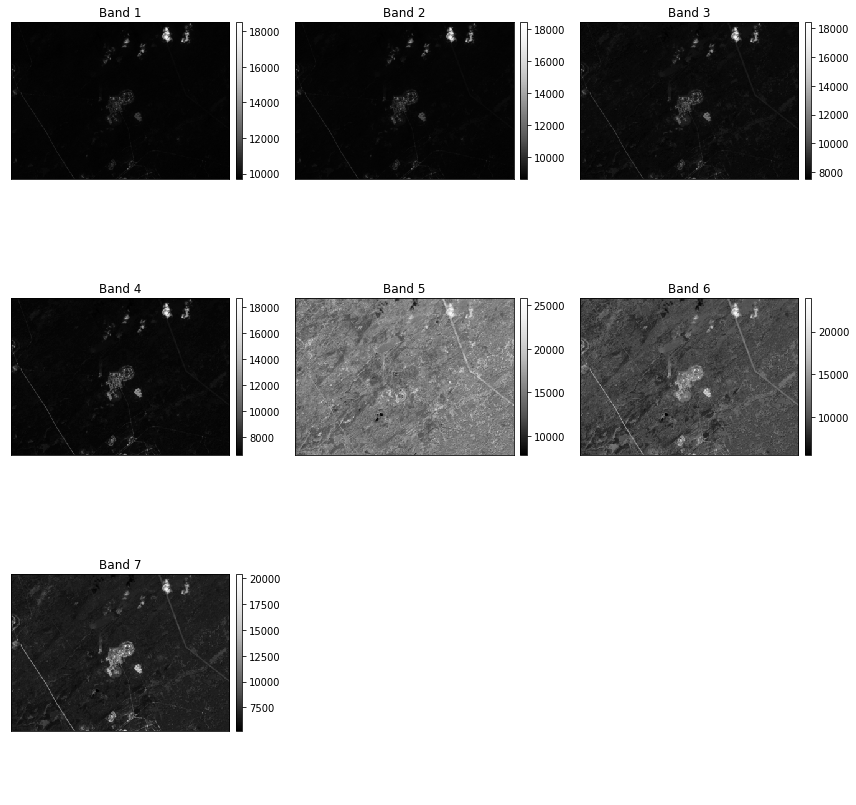

In [33]:
ep.plot_bands(arr_crop)
plt.show()

# Spectral Selection
This will enable you to select a desired band combination based on 
specific spectral bands of interest.

Please enter the desired band number to map to Red:5
Band # 5  will be mapped to Red.
Please enter the desired band number to map to Green:2
Band # 2  will be mapped to Green.
Please enter the desired band number to map to Blue:1
Band # 1  will be mapped to Blue.


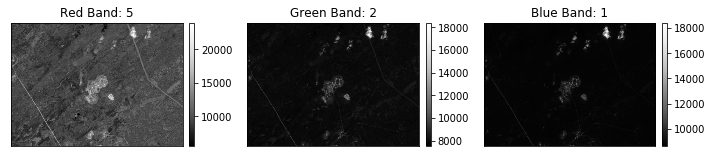

In [17]:
#establish integer type variables for three display bands
band1=0
band2=0
band3=0

#prompt and input the desired band numbers to be mapped to RGB
band1=int(input("Please enter the desired band number to map to Red:"))
print("Band #",band1," will be mapped to Red.\r")
band2=int(input("Please enter the desired band number to map to Green:"))
print("Band #",band2," will be mapped to Green.\r")
band3=int(input("Please enter the desired band number to map to Blue:"))
print("Band #",band3," will be mapped to Blue.\r")

titles = ["Red Band: "+str(band1), "Green Band: "+str(band2), "Blue Band: "+str(band3)]



# Plot bands using the earthpy function
ep.plot_bands(arr_crop[[band1, band2, band3]], 
              figsize=(10,10), 
              title=titles)
plt.show()


# Color Composite
<a href="https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_rgb.html">Reference link for python source</a>

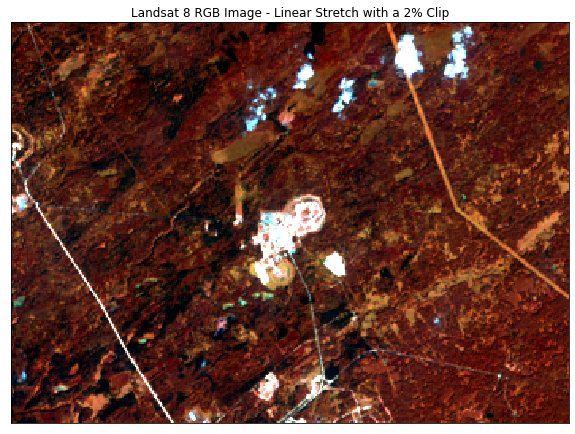

In [18]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot red, green, and blue bands, respectively
composite = ep.plot_rgb(arr_crop, rgb=(band1 ,band2 ,band3), stretch=True, str_clip=2, ax=ax, title="Landsat 8 RGB Image - Linear Stretch with a 2% Clip")
plt.show()

# Image Resampling
This will enable you to resample an image so that you can match Ground Sample Distance (GSD) 
between various sensor types. You shall be able to compare various image interpolation methods in the
event that you need to resample from a lower spatial resolution band to
a higher spatial resolution band.

<img src="L8pixelsizes.png">
<i>(Image source: https://landsat.gsfc.nasa.gov/landsat-8/landsat-8-overview)</i>

In [19]:
cropped_composite_path = os.path.join(directory, "cropped_composite.tif")

In [20]:
with rasterio.open(cropped_composite_path, 'w', **meta) as dst:
    dst.write(arr_crop)
    
cropped_composite = rasterio.open("cropped_composite.tif")

#plt.imshow(cropped_composite.read(2)) #debug statement

# Resample Cropped Color Composite
Four new resampled images will be generated, interpolating the cell values from native 30m GSD down to 10m GSD. Four interpolation methods will be used.<br>
The resampled images will be stored as new rasters in the working directory.<br>
<a href="https://pro.arcgis.com/en/pro-app/tool-reference/data-management/resample.htm">Reference the ArcGIS Pro Resampling (Data Management) Tool</a>

## Interpolation methods calculated:
<ol><li>Nearest Neighbor</li><li>Bilinear</li><li>Cubic</li><li>Majority</li></ol>




In [21]:
#reference links for python source
#https://pro.arcgis.com/en/pro-app/tool-reference/data-management/resample.htm

#resample down to 10m GSD using various interpolation methods and store them as new rasters in the working directory
arcpy.env.workspace=directory
arcpy.Resample_management("cropped_composite.tif", "resampled_nearest.tif", "10", "NEAREST")
arcpy.Resample_management("cropped_composite.tif", "resampled_bilinear.tif", "10", "BILINEAR")
arcpy.Resample_management("cropped_composite.tif", "resampled_cubic.tif", "10", "CUBIC")
arcpy.Resample_management("cropped_composite.tif", "resampled_majority.tif", "10", "MAJORITY")

<Result 'C:\\imagery folder\\LC08_L1TP_149021_20200809_20200809_01_RT\\resampled_majority.tif'>

In [22]:
#use rasterio to open the newly created rasters
resampled_nearest = rasterio.open("resampled_nearest.tif")
resampled_bilinear = rasterio.open("resampled_bilinear.tif")
resampled_cubic = rasterio.open("resampled_cubic.tif")
resampled_majority = rasterio.open("resampled_majority.tif")

In [23]:
#create multi-dimensional numpy arrays which contain the resampled raster data
arr_nearest = resampled_nearest.read()
arr_bilinear = resampled_bilinear.read()
arr_cubic = resampled_cubic.read()
arr_majority = resampled_majority.read()


# Suspect Pixel Selection from Resampled Results
<b>The following four cells will display the resampled rasters. You will be able to manipulate the image (pan, tilt, zoom)
as well as use your cursor to view the values of suspect pixels. The output format for the pixel values will be:</b><br>
   <i> (x, y) coordinates + [Red band value, Green band value, Blue band value] </i>
    

In [40]:
%matplotlib notebook

## Nearest Neighbor Resampled Image

<IPython.core.display.Javascript object>


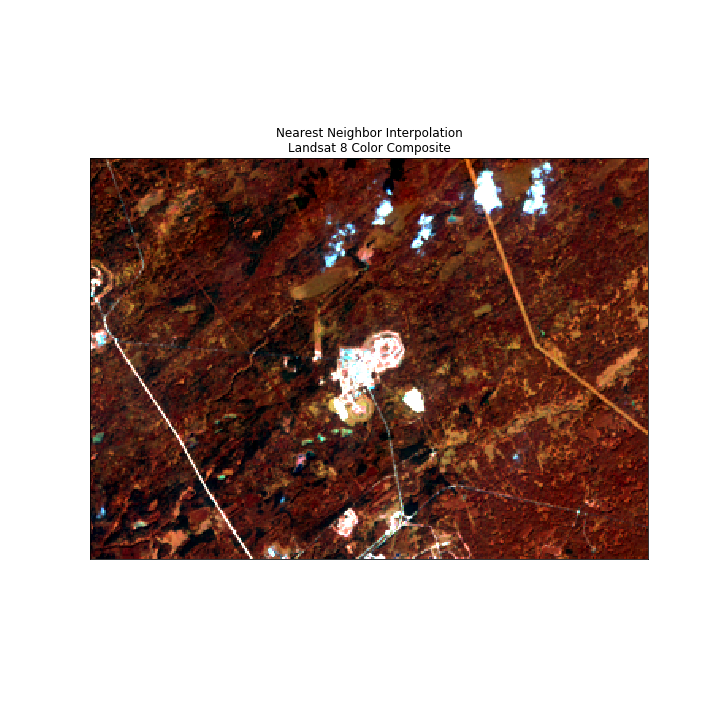

In [41]:
# Create figure with one raster that uses the NEAREST NEIGHBOR interpolation method
fig, ax = plt.subplots(figsize=(10, 10))

# Plot red, green, and blue bands, respectively
ep.plot_rgb(arr_nearest, rgb=(band1 ,band2 ,band3), stretch=True, str_clip=2, ax=ax, title="Nearest Neighbor Interpolation\nLandsat 8 Color Composite")
plt.show()

## Bilinear Resampled Image

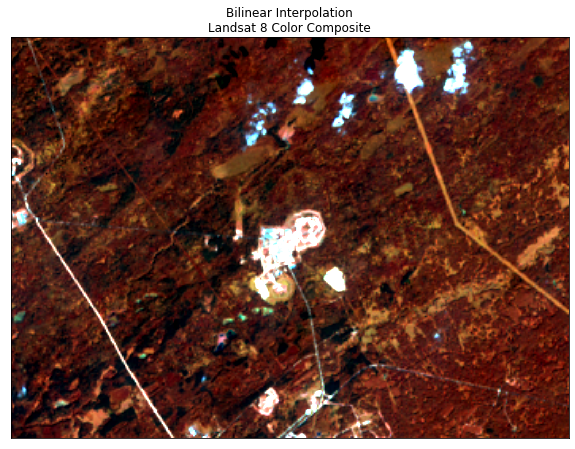

In [38]:
# Create figure with one raster that uses the BILINEAR interpolation method
fig, ax = plt.subplots(figsize=(10, 10))

# Plot red, green, and blue bands, respectively
ep.plot_rgb(arr_bilinear, rgb=(band1 ,band2 ,band3), stretch=True, str_clip=2, ax=ax, title="Bilinear Interpolation\nLandsat 8 Color Composite")
plt.show()

## Cubic Resampled Image

<IPython.core.display.Javascript object>


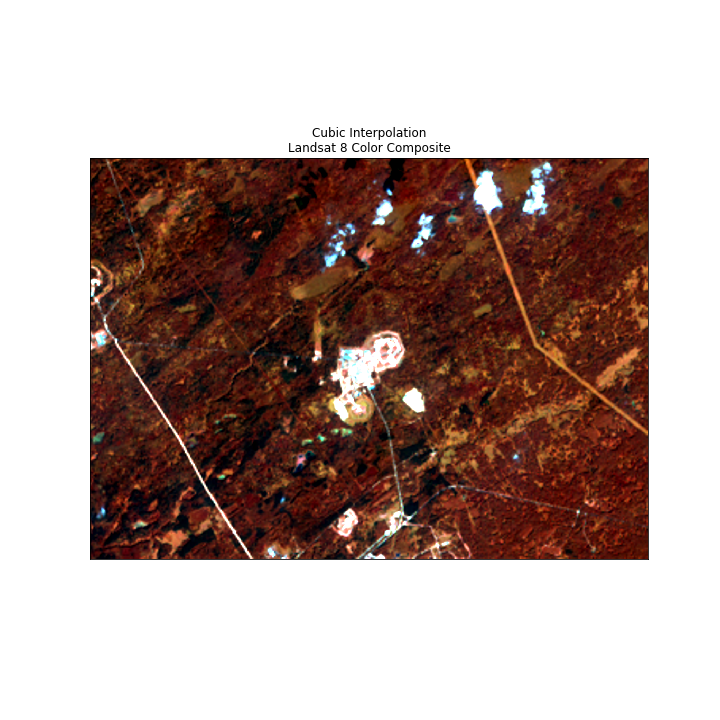

In [29]:
# Create figure with one raster that uses the CUBIC interpolation method
fig, ax = plt.subplots(figsize=(10,10))

# Plot red, green, and blue bands, respectively
ep.plot_rgb(arr_cubic, rgb=(band1 ,band2 ,band3), stretch=True, str_clip=2, ax=ax, title="Cubic Interpolation\nLandsat 8 Color Composite")
plt.show()

## Majority Resampled Image

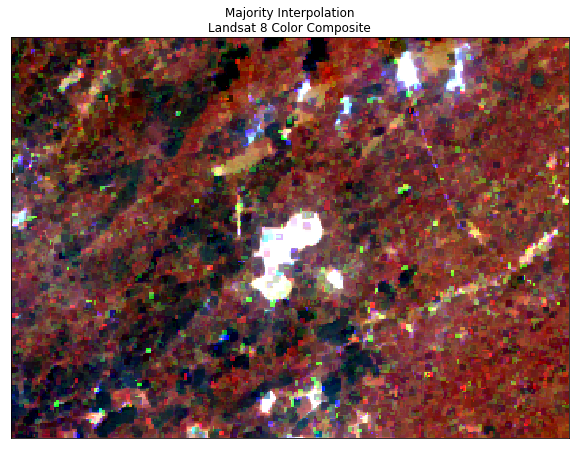

In [39]:
# Create figure with one raster that uses the MAJORITY interpolation method
fig, ax = plt.subplots(figsize=(10,10))

# Plot red, green, and blue bands, respectively
ep.plot_rgb(arr_majority, rgb=(band1 ,band2 ,band3), stretch=True, str_clip=2, ax=ax, title="Majority Interpolation\nLandsat 8 Color Composite")
plt.show()